# Rates and Feedback into Oscillators

Now that all of the above works and we can drive a neuronal population with the theta input from the ensemble of oscillators, let's take a look at how the ensemble is affected by the neurons using feedback.

We will make a new network; HH neurons will be driven by a _constant_ input to produce spikes; these spikes will be turned into rates through a LPF and these rates will be fed back into the oscillators.

In [1]:
from brian2 import *

INFO       Cache size for target "cython": 13528 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/nikos/.cython/brian_extensions" directory. [brian2]


Below we have the equations that we will use in the model. The Kuramoto oscillator equations have been adapted (now _X_ is `(linked)` to the rates).

In [2]:
# Kuramoto oscillators
kuramoto_eqs_stim = '''
    dTheta/dt = ((omega + (kN * PIF) - G*X*sin(Theta)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    Vm = sin(Theta)*mV : volt
    ThetaPreInput : 1
    omega : 1
    kN : 1
    G : 1
    X : 1 (linked) # this is linked to the firing rates
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    rhythm_test = coherence * (sin(phase)+1)/2 : 1
    rhythm_simple = rhythm*nA : amp
    rhythm_abs = abs(rhythm)*nA : amp
    rhythm_rect = rhythm_test*nA : amp
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''


# The neuronal model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I_ext)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I_ext : amp #(linked)
'''

# Spikes-2-Rates
eqs_FiringRateFilter = '''
    dY/dt = -Y/tauFR : 1/second
    drive = Y/Hz : 1
'''

Global parameters for the simulation.

In [3]:
# Parameters
duration = 1*second

# Oscillators
seed(42)
N = 50
f0 = 4 # center freq [Hz]
sigma = 0.5 # normal std

# HH model
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
N = 1e3

filter_params = {
    'tauFR' : 50*ms
}

Let's make the groups one by one:

In [4]:
# Kuramoto oscillators group
oscillators = NeuronGroup(N, kuramoto_eqs_stim, threshold='True', method='euler', name='Kuramoto_N_%d' %N)
oscillators.Theta = '2*pi*rand()' # uniform U~[0,2π]
oscillators.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
oscillators.kN = 10
oscillators.G = 15
osc_synapses = Synapses(oscillators, oscillators, on_pre=syn_kuramoto_eqs)
osc_synapses.connect(condition='i!=j')

# mean phase output
population = NeuronGroup(1, pop_avg_eqs)
r0 = 1/N * sum(exp(1j*oscillators.Theta))
population.x = real(r0)  # avoid division by zero
population.y = imag(r0)
average = Synapses(oscillators, population, syn_avg_eqs)
average.connect()

# --------------------------------------------------------------------------
# HH Neurons
neurons_HH = NeuronGroup(N, eqs_HH, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
neurons_HH.v = 'El+10*randn()*mV'

# Low-Pass Filter group
LPF = NeuronGroup(1, eqs_FiringRateFilter, namespace=filter_params, method='exponential_euler')
LPF.Y = 0

S_LPF = Synapses(neurons_HH, LPF, on_pre='Y_post += (1/tauFR)/%d'%N, namespace=filter_params)
S_LPF.connect()
# --------------------------------------------------------------------------


# Link Kuramoto oscillators' input X to firing rates (drive)
oscillators.X = linked_var(LPF, 'drive')

In [5]:
# add a few monitors
mon_osc = StateMonitor(oscillators, 'Theta', True)
mon_avg = StateMonitor(population, ['coherence', 'phase', 'rhythm', 'rhythm_rect'], record=True)

mon_spikes_HH = SpikeMonitor(neurons_HH)
mon_v_HH = StateMonitor(neurons_HH, ['I_ext', 'v'], record=True)

mon_LPF_drive = StateMonitor(LPF, ['drive', 'Y'], record=True)

In [6]:
# Make a network and add components
net_kur = Network()

# Oscillators
net_kur.add(oscillators)
net_kur.add(osc_synapses)
net_kur.add(population)
net_kur.add(average)

# Neurons
net_kur.add(neurons_HH)
net_kur.add(LPF)
net_kur.add(S_LPF)

# Monitors
net_kur.add(mon_osc)
net_kur.add(mon_avg)
net_kur.add(mon_spikes_HH)
net_kur.add(mon_v_HH)
net_kur.add(mon_LPF_drive)

In [7]:
# Run for a while
neurons_HH.I_ext = 0*nA
net_kur.run(500*ms)
neurons_HH.I_ext = 5*nA
net_kur.run(10*ms)
neurons_HH.I_ext = 0*nA
net_kur.run(duration-510*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]


Text(0.5, 0, 'Time (ms)')

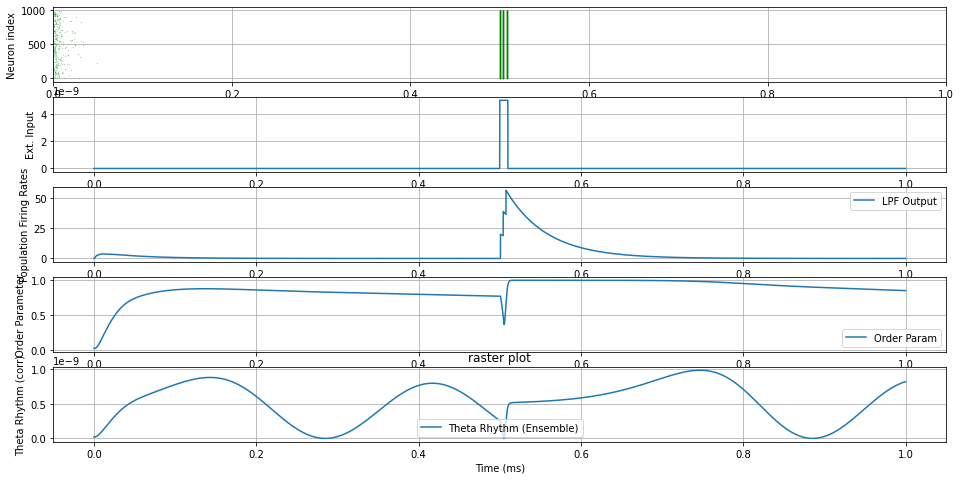

In [9]:
# Plot stuff
raster_fig, raster_ax = plt.subplots(nrows=5, ncols=1)
raster_fig.set_figheight(8)
raster_fig.set_figwidth(16)

title('raster plot')
raster_ax[0].plot(mon_spikes_HH.t/second, mon_spikes_HH.i, '.g', markersize=.5,alpha=0.5)
raster_ax[0].set_xlim([0,1])
raster_ax[0].set_ylabel('Neuron index')
raster_ax[0].grid()

raster_ax[1].plot(mon_v_HH.t/second, mon_v_HH.I_ext[0])
#raster_ax[1].set_ylim([-1,1])
raster_ax[1].set_ylabel('Ext. Input')
raster_ax[1].grid()

raster_ax[2].plot(mon_LPF_drive.t/second, mon_LPF_drive.drive[0], label='LPF Output')
raster_ax[2].set_ylabel('Population Firing Rates')
raster_ax[2].legend()
raster_ax[2].grid()

raster_ax[3].plot(mon_avg.t/second, mon_avg.coherence[0], '-', label='Order Param')
raster_ax[3].set_ylabel('Order Parameter')
raster_ax[3].legend()
raster_ax[3].grid()

raster_ax[4].plot(mon_avg.t/second, mon_avg.rhythm_rect[0], '-', label='Theta Rhythm (Ensemble)')
raster_ax[4].set_ylabel('Theta Rhythm (corr)')
raster_ax[4].legend()
raster_ax[4].grid()

raster_ax[4].set_xlabel('Time (ms)')
